## Lorenz63 System

This notebook evaluates the effectiveness our proposed **KoopSTD** on the well-known Lorenz63 system.

The dataset consists of segments extracted from 500-second simulated trajectories, encompassing five distinct behaviors: line-like, ring-like, Periodic[1-1-2-2], Periodic[1-2], and Chaotic dynamics. For each behavioral type, we include 40 randomly sampled 20-second clips.

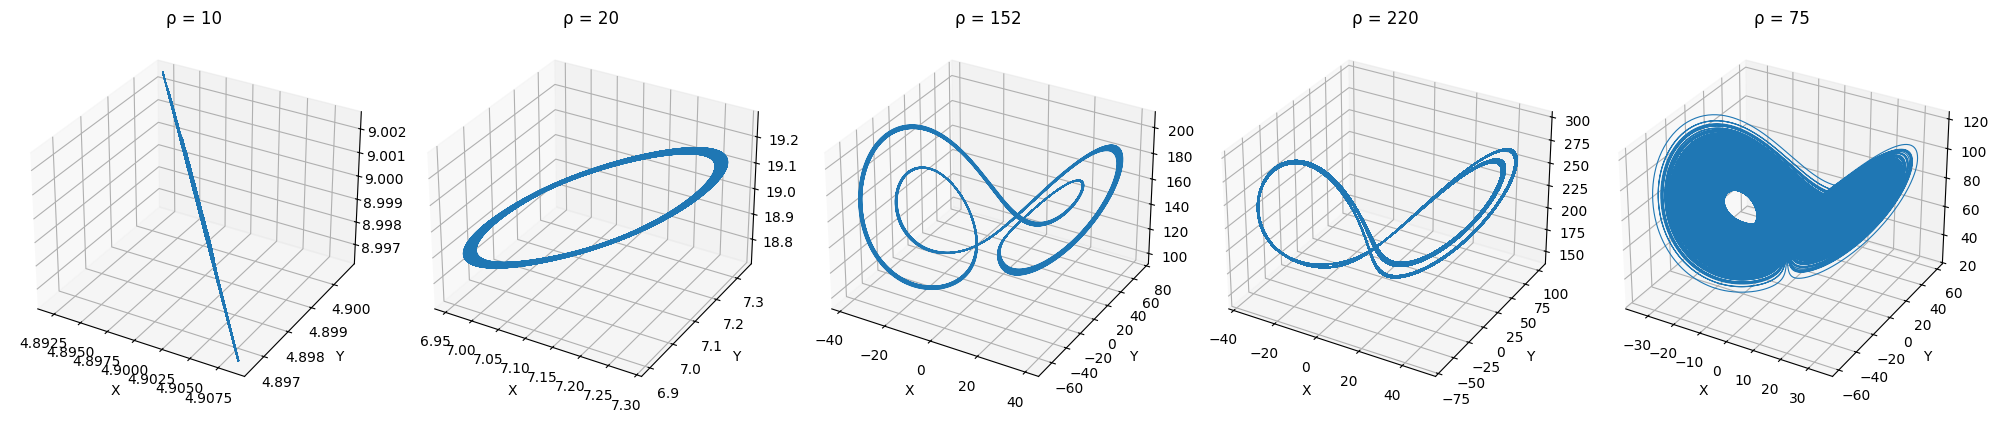

In [4]:
from koopstd.dynametric import KoopOpMetric
from koopstd.eval import MetricEvaluator
from koopstd.datasets import Lorenz63
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE, MDS
import pandas as pd

lorenz = Lorenz63(rho_values=[10, 20, 152, 220, 75], num_clips=40)
lorenz.visualize_data(time_range=None)

In [2]:
data = lorenz.data
print(len(data), data[0].shape)

200 (20000, 3)


### KoopSTD (Ours)

In [5]:
koopstd_params = {'hop_size': 1, 'win_len': 500, 'rank': 10, 'lamb': 0}  # hyper-parameters for KoopSTD(l,s,r)
wasserstein_params = {'p': 1, 'method': 'emd'}  # hyper-parameters for Wasserstein distance

koopstd = KoopOpMetric(X=lorenz.data, kmd_method='koopstd', kmd_params=koopstd_params, dist='wasserstein', dist_params=wasserstein_params, device='cuda')
koopstd_dist_matrix = koopstd.fit_score()

# Evaluate the performance of KoopSTD by Silhouette Coefficient
me = MetricEvaluator(distance_matrix=koopstd_dist_matrix, cluster_sizes=[40, 40, 40, 40, 40])
silhouette = me.evaluate()
print(silhouette)

0.9288562345424435


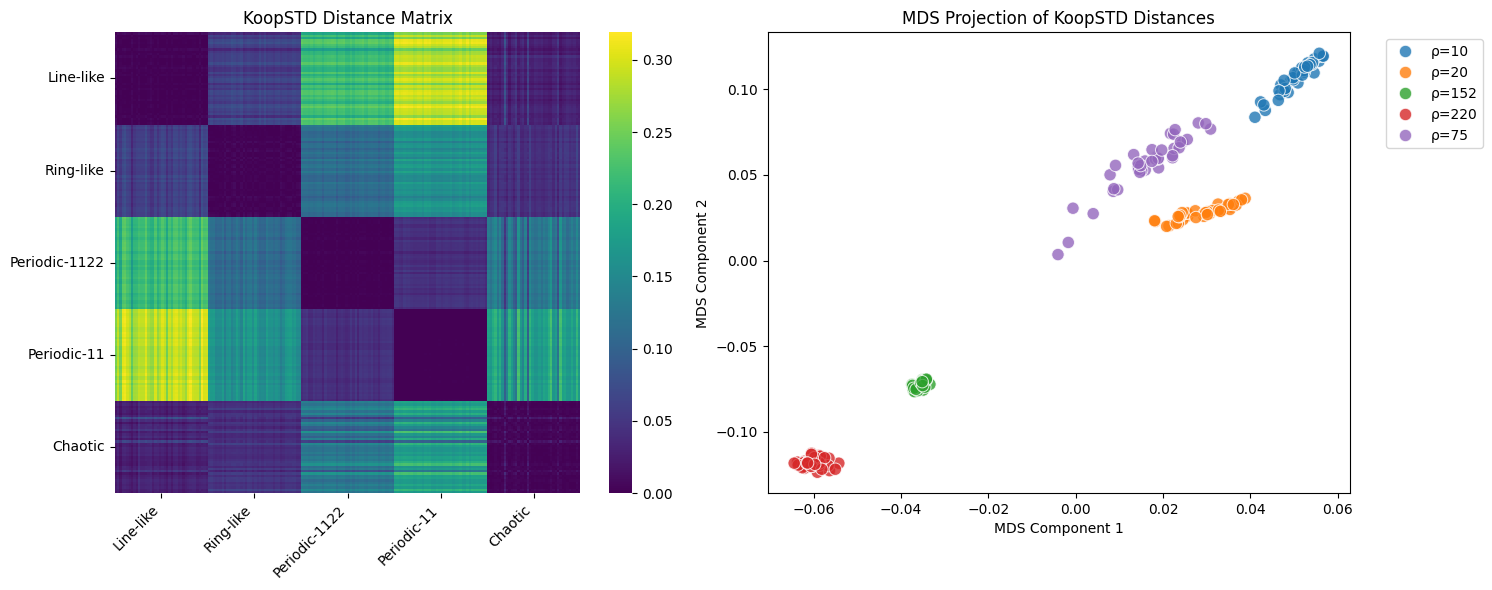

In [ ]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot heatmap
sns.heatmap(koopstd_dist_matrix, cmap='viridis', ax=axes[0])
lorenz_names = ['Line-like', 'Ring-like', 'Periodic-1122', 'Periodic-11', 'Chaotic']
axes[0].set_title('KoopSTD Distance Matrix')

# Set custom tick labels
tick_positions = [20, 60, 100, 140, 180]  # Middle of each group (40 clips each)
axes[0].set_xticks(tick_positions)
axes[0].set_yticks(tick_positions)
axes[0].set_xticklabels(lorenz_names, rotation=45, ha='right')
axes[0].set_yticklabels(lorenz_names, rotation=0)

# Perform MDS for visualization
vis = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
embedding = vis.fit_transform(koopstd_dist_matrix)

# Create DataFrame for scatter plot
df = pd.DataFrame()
df["x"] = embedding[:, 0]
df["y"] = embedding[:, 1]

# Add labels for different rho values (5 rho values, 40 clips each)
rho_labels = []
rho_values = [10, 20, 152, 220, 75]
for rho in rho_values:
    rho_labels.extend([f"ρ={rho}"] * 40)  # 40 clips per rho value
df["System"] = rho_labels

# Plot scatter with improved styling
sns.scatterplot(data=df, x="x", y="y", hue="System", ax=axes[1], s=80, alpha=0.8)
axes[1].set_title('MDS Projection of KoopSTD Distances')
axes[1].set_xlabel('MDS Component 1')
axes[1].set_ylabel('MDS Component 2')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

### HAVOK-based DSA (Ostrow et al., 2024)
For computational efficiency, we replace the Procrustes analysis for vector fields (PAVF) with Wasserstein when calculating distances between spectra in this notebook. 

0.481643830298269


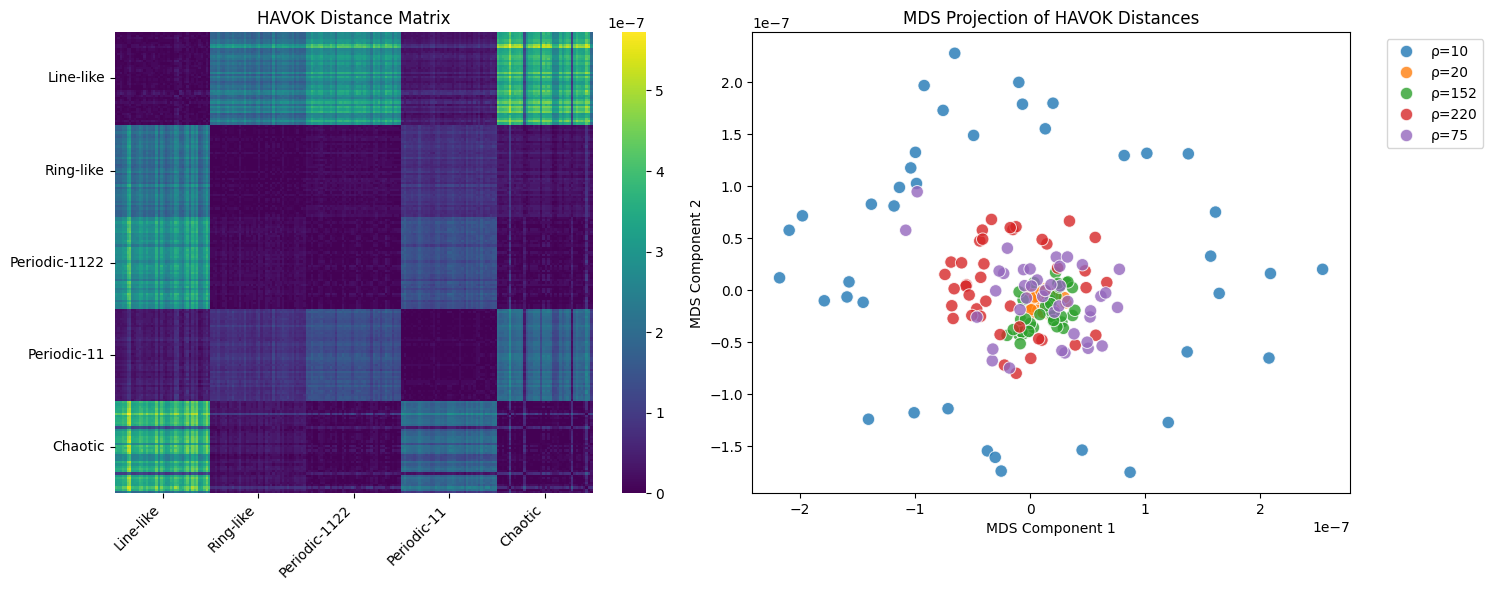

In [6]:
havok_params = {'n_delays': 40, 'delay_interval': 5, 'rank': 10}  # hyper-parameters for HAVOK(p,q,r)
wasserstein_params = {'p': 1, 'method': 'emd'}  # hyper-parameters for Wasserstein distance

havok = KoopOpMetric(X=lorenz.data, kmd_method='havok', kmd_params=havok_params, dist='wasserstein', dist_params=wasserstein_params, device='cuda')
havok_dist_matrix = havok.fit_score()

me = MetricEvaluator(distance_matrix=havok_dist_matrix, cluster_sizes=[40, 40, 40, 40, 40])
silhouette = me.evaluate()
print(silhouette)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot heatmap
sns.heatmap(havok_dist_matrix, cmap='viridis', ax=axes[0])
lorenz_names = ['Line-like', 'Ring-like', 'Periodic-1122', 'Periodic-11', 'Chaotic']
axes[0].set_title('HAVOK Distance Matrix')

# Set custom tick labels
tick_positions = [20, 60, 100, 140, 180]  # Middle of each group (40 clips each)
axes[0].set_xticks(tick_positions)
axes[0].set_yticks(tick_positions)
axes[0].set_xticklabels(lorenz_names, rotation=45, ha='right')
axes[0].set_yticklabels(lorenz_names, rotation=0)

# Perform MDS for visualization
vis = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
embedding = vis.fit_transform(havok_dist_matrix)

# Create DataFrame for scatter plot
df = pd.DataFrame()
df["x"] = embedding[:, 0]
df["y"] = embedding[:, 1]

# Add labels for different rho values (5 rho values, 40 clips each)
rho_labels = []
rho_values = [10, 20, 152, 220, 75]
for rho in rho_values:
    rho_labels.extend([f"ρ={rho}"] * 40)  # 40 clips per rho value
df["System"] = rho_labels

# Plot scatter with improved styling
sns.scatterplot(data=df, x="x", y="y", hue="System", ax=axes[1], s=80, alpha=0.8)
axes[1].set_title('MDS Projection of HAVOK Distances')
axes[1].set_xlabel('MDS Component 1')
axes[1].set_ylabel('MDS Component 2')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()